# Running the model

Setup a `feisty` integration.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import yaml

import feisty

## Configure testcase to run

TODO: this is using the first column (which I believe is shallowest); want to add deepest column as well.
That will require refactoring the yaml file and also changing test_ds.

In [3]:
with open("matlab_first_timestep.yaml") as f:
    baselines = yaml.safe_load(f)


def compare(baselines_dict, da_or_ds, full_table=True, markdown_formatting=False):
    if markdown_formatting:
        if "dimname" in baselines_dict:
            print(f"| {baselines_dict['dimname']} | Matlab Value | Python Value | Rel Err |")
        else:
            print(f"|  | Matlab Value | Python Value | Rel Err |")
        print("| --- | --- | --- | --- |")
        seps = ["| ", " | ", " | ", " |"]
    else:
        seps = ["", ": ", ", ", ""]
    if "dimname" in baselines_dict:
        all_vars = da_or_ds[baselines_dict["dimname"]].data
    else:
        all_vars = baselines_dict["values"]
    for var in all_vars:
        if "dimname" in baselines_dict:
            da = da_or_ds
            sel_dict = {baselines_dict["dimname"]: var}
        else:
            da = da_or_ds[var]
            sel_dict = {}
        matlab_val = baselines_dict["values"][var]
        py_val = da.sel(sel_dict).data
        if matlab_val != 0:
            rel_err = (py_val - matlab_val) / matlab_val
            if rel_err < 0:
                rel_err = -rel_err
        else:
            if py_val == 0:
                rel_err = 0
            elif py_val > 0:
                rel_err = np.inf
            elif py_val < 0:
                rel_err = -np.inf
        if full_table or rel_err > 1e-2:
            print(
                f"{seps[0]}{var}{seps[1]}{matlab_val:10.4e}{seps[2]}"
                + f"{py_val:10.4e}{seps[2]}{rel_err:10.4e}{seps[-1]}"
            )

In [4]:
matlab_script = "test_locs3"

if matlab_script == "test_case":
    testcase = feisty.driver.simulate_testcase("tanh_shelf", "cyclic")
elif matlab_script == "test_locs3":
    kwargs = {'forcing_yaml': './forcing.yaml', 'forcing_key': matlab_script}
    testcase = feisty.driver.simulate_testcase(
        "from_disk", "from_disk", domain_kwargs=kwargs, forcing_kwargs=kwargs
    )
else:
    raise ValueError(f"unknown matlab_script '{matlab_script}'")

In [5]:
compare(
    baselines[matlab_script]["day1"]["forcing"],
    testcase.forcing.isel(time=0, X=0, zooplankton=0),
    markdown_formatting=True,
)

|  | Matlab Value | Python Value | Rel Err |
| --- | --- | --- | --- |
| T_pelagic | 4.7453e+00 | 4.7453e+00 | 0.0000e+00 |
| T_bottom | 4.7647e+00 | 4.7647e+00 | 0.0000e+00 |
| zooC | 7.0175e+00 | 7.0175e+00 | 0.0000e+00 |
| poc_flux_bottom | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 |
| zoo_mort | 5.2470e-02 | 5.2470e-02 | 1.3225e-16 |


## Run the model


In [6]:
%%time

nsteps = 365
make_plot = True
testcase.run(nsteps)
testcase.ds

CPU times: user 1min 38s, sys: 148 ms, total: 1min 38s
Wall time: 1min 41s


<xarray.Dataset>
Dimensions:                    (X: 3, group: 9, time: 365, fish: 8, feeding_link: 19)
Coordinates:
  * X                          (X) int64 0 1 2
  * group                      (group) <U12 'Sf' 'Sp' ... 'Ld' 'benthic_prey'
  * fish                       (fish) <U2 'Sf' 'Sp' 'Sd' 'Mf' ... 'Md' 'Lp' 'Ld'
  * feeding_link               (feeding_link) <U15 'Sf_Zoo' ... 'Ld_benthic_p...
    predator                   (feeding_link) <U2 'Sf' 'Sp' 'Sd' ... 'Ld' 'Ld'
    prey                       (feeding_link) <U12 'Zoo' ... 'benthic_prey'
Dimensions without coordinates: time
Data variables: (12/16)
    biomass                    (time, group, X) float64 1e-05 ... 0.6438
    T_habitat                  (time, fish, X) float64 4.745 23.11 ... 17.82
    ingestion_rate             (time, fish, X) float64 0.09699 ... 2.989e-05
    predation_flux             (time, fish, X) float64 1.262e-12 ... 0.0
    predation_rate             (time, fish, X) float64 1.262e-07 ... 0.0
    metabolism_rate            (time, fish, X) float64 0.0136 ... 0.004725
    ...                         ...
    recruitment_flux           (time, fish, X) float64 8.298e-10 ... 2.012e-06
    fish_catch_rate            (time, fish, X) float64 0.0 0.0 ... 0.0008219
    encounter_rate_link        (time, feeding_link, X) float64 2.067 ... 0.0
    encounter_rate_total       (time, fish, X) float64 2.067 5.293 ... 2.998e-05
    consumption_rate_max_pred  (time, fish, X) float64 0.1018 0.3236 ... 0.01037
    consumption_rate_link      (time, feeding_link, X) float64 0.09699 ... 0.0

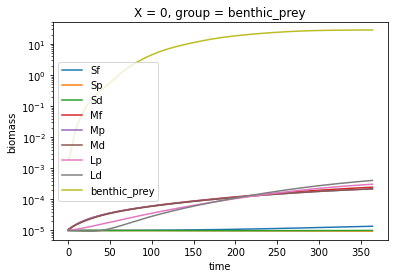

In [7]:
check_key = f"day{nsteps}"
test_ds = testcase.ds.isel(X=0, time=-1)

if nsteps > 1:
    if make_plot:
        for group in test_ds.group.data:
            testcase.ds.biomass.sel(group=group).isel(X=0).plot()
        if matlab_script == "test_case":
            plt.ylim([1e-6, 1])
        if matlab_script == "test_locs3":
            plt.ylim([5e-6, 50])
        plt.yscale("log")
        plt.legend(test_ds.group.data)

In [8]:
compare(
    baselines[matlab_script][check_key]["biomass"],
    test_ds["biomass"],
    markdown_formatting=True,
)

| group | Matlab Value | Python Value | Rel Err |
| --- | --- | --- | --- |
| Sf | 1.3654e-05 | 1.3654e-05 | 0.0000e+00 |
| Sp | 9.5706e-06 | 9.5706e-06 | 0.0000e+00 |
| Sd | 1.0002e-05 | 1.0002e-05 | 1.6937e-16 |
| Mf | 2.4689e-04 | 2.4689e-04 | 2.1957e-16 |
| Mp | 2.1750e-04 | 2.1750e-04 | 0.0000e+00 |
| Md | 2.1868e-04 | 2.1868e-04 | 0.0000e+00 |
| Lp | 3.0769e-04 | 3.0769e-04 | 1.7618e-16 |
| Ld | 4.0795e-04 | 4.0795e-04 | 0.0000e+00 |
| benthic_prey | 2.8417e+01 | 2.8417e+01 | 1.6253e-15 |
